In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL
import urllib
from torchvision import datasets, transforms

c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [18]:
mnist_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:10000]

In [4]:
criterion = nn.BCELoss()

In [5]:
img_to_tensor = transforms.ToTensor()

In [26]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
    #nn.Linear(28*28, 300),
    #nn.LeakyReLU(0.2),
    #nn.Linear(300, 100),
    #nn.LeakyReLU(0.2),
    #nn.Linear(100, 1),
    #nn.Sigmoid())
    nn.Conv2d(3, 64, 4, 2, 1), # 64
    nn.LeakyReLU(0.2),
    nn.Conv2d(64, 128, 4, 2, 1), # 32 
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    nn.Conv2d(128, 256, 4, 2 ,1), # 16
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    nn.Conv2d(256, 512, 4, 2, 1), # 8
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2),
    nn.Conv2d(512, 1, 4, 1),
    nn.Sigmoid()
    )
  def forward(self, x):
    #x = x.view(x.size(0), -1)
    #out = self.model(x)
    #return out.view(x.size(0))
    return self.model(x)

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
    #nn.Linear(100, 300),
    #nn.LeakyReLU(0.2),
    #nn.Linear(300, 28*28),
    #nn.Sigmoid())
    
    )
  def forward(self, x):
    out = self.model(x).view(x.size(0), 1, 28, 28)
    return out

In [19]:
def train_discriminator(discriminator, generator, images):
  # batch_size = img_to_tensor(images).size(0)
  batch_size = images.size(0)

  noise = torch.randn(batch_size, 100)
  fake_images = generator(noise)
  inputs = torch.cat([images, fake_images])
  labels = torch.cat([torch.zeros(batch_size), # Real
  torch.ones(batch_size)]) # Fake
  outputs = discriminator(inputs)
  loss = criterion(outputs, labels)
  return outputs, loss


In [8]:
def train_generator(discriminator, generator, images):
  batch_size = images.size(0)
  noise = torch.randn(batch_size, 100)
  fake_images = generator(noise)
  outputs = discriminator(fake_images)
  # Only looks at fake outputs
  # gets rewarded if we fool the discriminator!
  labels = torch.zeros(batch_size)
  loss = criterion(outputs, labels)
  return fake_images, loss


In [29]:
def train(discriminator, generator, lr, epochs, train_loader  ):
  torch.manual_seed(42)
  optimizerDisc = optim.Adam(discriminator.parameters(), lr = lr)
  optimizerGen = optim.Adam(generator.parameters(), lr = lr)

  Gtrain_acc, Gval_acc, iters, Gtrain_loss, Gval_loss = [], [], [], [], []
  Dtrain_acc, Dval_acc, iters, Dtrain_loss, Dval_loss = [], [], [], [], []
  genImgs = []

  start_time = time.time()
  for epoch in range(epochs):
    Gtotal_train_loss = 0.0
    Dtotal_train_loss = 0.0
    iteration = 0
    for imgs, __ in train_loader:
      outputD, lossD = train_discriminator(discriminator, generator, imgs)
      lossD.backward()
      Dtotal_train_loss += lossD.item()
      optimizerDisc.step()
      optimizerDisc.zero_grad()

      outputG, lossG = train_generator(discriminator, generator, imgs)
      lossG.backward()
      Gtotal_train_loss += lossG.item()
      optimizerGen.step()
      optimizerGen.zero_grad()
      iteration += 1

    Gtrain_loss.append(float(Gtotal_train_loss) / (iteration + 1))
    #Gval_loss.append(evaluate(model, valid_loader, criterion))
    Dtrain_loss.append(float(Dtotal_train_loss) / (iteration + 1))

    print(("Epoch {}: Gen Train loss: {}, Disc Train loss: {}").format(
               # + "Gen Validation loss: {}, Disc Validation loss: {}").format(
                   epoch + 1,
                   #train_acc[epoch],
                   Gtrain_loss[epoch],
                   Dtrain_loss[epoch]))
                   #val_acc[epoch],
                   #val_loss[epoch]))
    # Save the current model (checkpoint) to a file
    #model_path = get_model_name(model.name, learning_rate, epoch)
    #torch.save(model.state_dict(), model_path)
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  #print(("Final Train Accuracy: {}, |"+
  #             "Final Validation Accuracy: {}").format(
  #                 train_acc[-1],
  #                 val_acc[-1],))
#return train_acc, train_loss, val_acc, val_loss
  noise = torch.randn(64, 100)
  fake_imgs = generator(noise).detach()
  genImgs.append(fake_imgs)
  return Gtrain_loss, Dtrain_loss, genImgs

def plot(Gtrain_loss, Dtrain_loss):
    # Plotting
    plt.title("Gen Train Loss vs Disc Train Loss")
    n = len(Gtrain_loss) # number of epochs
    plt.plot(range(1,n+1), Gtrain_loss, label="Gen Train")
    plt.plot(range(1,n+1), Dtrain_loss, label="Disc Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def check(dataLoader, genImgs):
  real = next(iter(dataLoader))

  plt.figure(figsize = (15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real")
  plt.imshow(np.transpose(real[0], (1,2,0)))

  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake")
  plt.imshow(np.transpose(genImgs[0], (1,2,0)))
  plt.show()

In [45]:
generator = Generator()
discriminator = Discriminator()

In [62]:
discriminator = Discriminator()

In [67]:
Gtrain_loss, Dtrain_loss, genImgs = train(discriminator, generator, 0.01, 5000, torch.utils.data.DataLoader(mnist_train, batch_size=128))

Epoch 1: Gen Train loss: 0.4028701851144433, Disc Train loss: 0.6144884865731001


KeyboardInterrupt: 

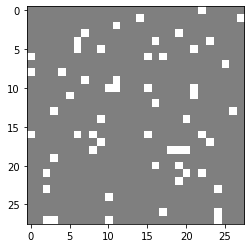

In [66]:
import matplotlib.pyplot as plt

import torchvision


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

imshow(genImgs[0][0])